In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import os


Mounted at /content/drive/


In [2]:
# Finding the Data Directory
data_dir = '/content/drive/My Drive/Ml_IR/24_Labels/'
os.chdir(data_dir)

# List the contents of the directory
print(os.listdir())

print("------------")


['ir_spectroscopy_dataset.pt', 'ir_model_checkpoint_(4L)_(L2)_v1.pth', 'IR_NN(4L)(24)_with_L2.ipynb']
------------


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

data = torch.load('ir_spectroscopy_dataset.pt')
X_values = data['X_values']
Y_values = data['Y_values']
Labels = data['Labels']

#print(X_values)


def preprocess_data(X_values, Y_values, Labels, cut_front=10, cut_end=10):
    """
    Preprocess the X_values and Y_values tensors by trimming a few points from the beginning and end,
    and removing data points with all NaN values or only NaN intensities.

    Parameters:
    - X_values: torch.Tensor
        The tensor containing the X values (wavenumbers) of the IR spectra
    - Y_values: torch.Tensor
        The tensor containing the Y values of the IR spectra
    - Labels: torch.Tensor
        The tensor containing the labels corresponding to Y_values
    - cut_front: int, default=10
        The number of data points to cut from the front of each spectrum
    - cut_end: int, default=10
        The number of data points to cut from the end of each spectrum

    Returns:
    - processed_X: torch.Tensor
        The processed X values tensor
    - processed_Y: torch.Tensor
        The processed Y values tensor
    - processed_Labels: torch.Tensor
        The processed labels tensor
    """
    # Trim the front and end of each spectrum
    processed_X = X_values[cut_front:-cut_end]
    processed_Y = Y_values[:, cut_front:-cut_end]

    # Create a mask for non-NaN rows and rows that are not all NaN
    mask = ~torch.isnan(processed_Y).all(dim=1) & ~torch.isnan(processed_Y).any(dim=1)

    # Apply the mask to Y_values and Labels
    processed_Y = processed_Y[mask]
    processed_Labels = Labels[mask]

    return processed_X, processed_Y, processed_Labels

# Example usage:
processed_X_values, processed_Y_values, processed_Labels = preprocess_data(X_values, Y_values, Labels)
print(f"Original X shape: {X_values.shape}, Processed X shape: {processed_X_values.shape}")
print(f"Original Y shape: {Y_values.shape}, Processed Y shape: {processed_Y_values.shape}")
print(f"Original labels: {Labels.shape}, Processed labels: {processed_Labels.shape}")



<ipython-input-3-f91958e94e04>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('ir_spectroscopy_dataset.pt')


Original X shape: torch.Size([1000]), Processed X shape: torch.Size([980])
Original Y shape: torch.Size([141, 1000]), Processed Y shape: torch.Size([139, 980])
Original labels: torch.Size([141, 24]), Processed labels: torch.Size([139, 24])


In [4]:
import numpy as np
import torch

def select_diverse_examples(processed_Y_values, processed_Labels, num_examples=10):
    num_samples = processed_Y_values.shape[0]
    num_labels = processed_Labels.shape[1]

    # Convert Labels to numpy for easier manipulation
    labels_np = processed_Labels.cpu().numpy()

    selected_indices = []
    remaining_indices = list(range(num_samples))

    while len(selected_indices) < num_examples and remaining_indices:
        if not selected_indices:
            # Select the first example randomly
            idx = np.random.choice(remaining_indices)
        else:
            # Calculate the Hamming distance to already selected examples
            distances = []
            for idx in remaining_indices:
                dist = [np.sum(labels_np[idx] != labels_np[sel_idx]) for sel_idx in selected_indices]
                distances.append(np.mean(dist))

            # Select the example with distance closest to the average
            avg_dist = np.mean(distances)
            idx = min(remaining_indices, key=lambda i: abs(distances[remaining_indices.index(i)] - avg_dist))

        selected_indices.append(idx)
        remaining_indices.remove(idx)

    # Create test set
    Y_test = processed_Y_values[selected_indices]
    Labels_test = processed_Labels[selected_indices]

    # Create train set (all indices not in selected_indices)
    train_indices = list(set(range(num_samples)) - set(selected_indices))
    Y_train = processed_Y_values[train_indices]
    Labels_train = processed_Labels[train_indices]

    return Y_train, Labels_train, Y_test, Labels_test

# Use the function to split the dataset
Y_train, Labels_train, Y_test, Labels_test = select_diverse_examples(processed_Y_values, processed_Labels)

print(f"Training set shape: {Y_train.shape}")
print(f"Training labels shape: {Labels_train.shape}")
print(f"Test set shape: {Y_test.shape}")
print(f"Test labels shape: {Labels_test.shape}")

# Verify that we have diverse examples in the test set
print("\nUnique label combinations in test set:")
for i in range(len(Labels_test)):
    print(f"Example {i+1}: {Labels_test[i].nonzero().squeeze().tolist()}")

Training set shape: torch.Size([129, 980])
Training labels shape: torch.Size([129, 24])
Test set shape: torch.Size([10, 980])
Test labels shape: torch.Size([10, 24])

Unique label combinations in test set:
Example 1: [13, 23]
Example 2: 0
Example 3: [1, 15, 23]
Example 4: [7, 8, 23]
Example 5: [7, 16, 23]
Example 6: [1, 6, 23]
Example 7: [6, 7, 13, 23]
Example 8: 0
Example 9: [5, 6, 23]
Example 10: [0, 6]


In [5]:
#----// NN //---------------------------


class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.g = torch.Generator()

        self.W1 = torch.nn.Parameter(torch.randn((980, 4000), generator=self.g))
        self.b1 = torch.nn.Parameter(torch.randn(4000, generator=self.g))
        self.W2 = torch.nn.Parameter(torch.randn((4000, 2000), generator=self.g))
        self.b2 = torch.nn.Parameter(torch.randn(2000, generator=self.g))
        self.W3 = torch.nn.Parameter(torch.randn((2000, 500), generator=self.g))
        self.b3 = torch.nn.Parameter(torch.randn(500, generator=self.g))
        self.W4 = torch.nn.Parameter(torch.randn((500, 24), generator=self.g))
        self.b4 = torch.nn.Parameter(torch.randn(24, generator=self.g))

        # Add dropout layers
        self.dropout1 = torch.nn.Dropout(0.2)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.dropout3 = torch.nn.Dropout(0.2)

        print(f"The NN has: {sum(p.numel() for p in self.parameters())} parameters")

    def forward(self, Y_values, Labels):
        h = torch.sigmoid(Y_values @ self.W1 + self.b1)
        h = self.dropout1(h)
        h2 = torch.sigmoid(h @ self.W2 + self.b2)
        h2 = self.dropout2(h2)
        h3 = torch.sigmoid(h2 @ self.W3 + self.b3)
        h3 = self.dropout3(h3)
        logits = h3 @ self.W4 + self.b4
        out = torch.sigmoid(logits)

        # Create a target tensor from Labels
        target = Labels.to(logits.device)

        # Compute binary cross-entropy loss
        loss = torch.nn.functional.binary_cross_entropy(out, target)

        return loss, out

    def __call__(self, data_tensor):
        # Ensure data_tensor is on the same device as the model
        data_tensor = data_tensor.to(self.W1.device)

        h = torch.sigmoid(data_tensor @ self.W1 + self.b1)
        h2 = torch.sigmoid(h @ self.W2 + self.b2)
        h3 = torch.sigmoid(h2 @ self.W3 + self.b3)
        logits = h3 @ self.W4 + self.b4
        out = torch.sigmoid(logits)

        return out

nn_model = NN()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-1)  # Changed to Adam optimizer with lower learning rate and added weight decay

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU
nn_model = nn_model.to(device)

# Move data tensors to GPU
Labels_train = Labels_train.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)
Labels_test = Labels_test.to(device)

print("Model and data moved to GPU successfully.")

# L2 regularization is now handled by the optimizer's weight_decay parameter


The NN has: 12938524 parameters
Using device: cuda
Model and data moved to GPU successfully.


In [6]:
import torch
import torch.nn as nn

class ImprovedNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(980, 4000),
            nn.BatchNorm1d(4000),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(4000, 2000),
            nn.BatchNorm1d(2000),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(2000, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.layer4 = nn.Linear(500, 24)

        # Initialize weights using He initialization
        self.apply(self._init_weights)

        print(f"The NN has: {sum(p.numel() for p in self.parameters())} parameters")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def forward(self, Y_values, Labels):
        """
        Forward pass for training.

        Args:
            Y_values (torch.Tensor): Input features.
            Labels (torch.Tensor): Ground truth labels.

        Returns:
            tuple: (loss, output)
        """
        h = self.layer1(Y_values)
        h2 = self.layer2(h)
        h3 = self.layer3(h2)
        logits = self.layer4(h3)
        out = torch.sigmoid(logits)

        # Create a target tensor from Labels
        target = Labels.to(logits.device)

        # Compute binary cross-entropy loss
        loss = nn.functional.binary_cross_entropy(out, target)

        return loss, out

    def __call__(self, data_tensor):
        """
        Inference pass.

        Args:
            data_tensor (torch.Tensor): Input features.

        Returns:
            torch.Tensor: Model predictions.
        """
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            # Ensure data_tensor is on the same device as the model
            data_tensor = data_tensor.to(next(self.parameters()).device)

            # Add a batch dimension if it's not present
            if data_tensor.dim() == 1:
                data_tensor = data_tensor.unsqueeze(0)

            h = self.layer1(data_tensor)
            h2 = self.layer2(h)
            h3 = self.layer3(h2)
            logits = self.layer4(h3)
            out = torch.sigmoid(logits)

            # Remove the batch dimension if we added it
            if out.shape[0] == 1:
                out = out.squeeze(0)

            return out

# Initialize the model
nn_model = ImprovedNN()
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=0.001, weight_decay=1e-2)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU
nn_model = nn_model.to(device)

# Move data tensors to GPU (assuming these variables exist)
Labels_train = Labels_train.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)
Labels_test = Labels_test.to(device)

print("Model and data moved to GPU successfully.")

The NN has: 12951524 parameters
Using device: cuda
Model and data moved to GPU successfully.


In [20]:

#----// Training Loop //---------------------------

optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.00001)  # Using Adam optimizer with lower learning rate

num_epochs = 1000  # Set a maximum number of epochs
best_loss = float('inf')
patience = 100  # Number of epochs to wait for improvement before early stopping
no_improve = 0
epoch = 0

#for epoch in range(num_epochs):
while True:
    nn_model.train()  # Set the model to training mode
    optimizer.zero_grad()
    loss, _ = nn_model.forward(Y_train, Labels_train)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


    """
    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early stopping triggered. No improvement for {patience} epochs.")
        break
    """

    if loss.item() < 5e-6:
        print("Reached Stop Point!!")
        print(f"Converged after {epoch+1} epochs.")
        break

print(f"Training completed. Final loss: {loss.item()}")



Streaming output truncated to the last 5000 lines.
Epoch 1, Loss: 2.8543521693791263e-05
Epoch 1, Loss: 3.182068758178502e-05
Epoch 1, Loss: 3.178249971824698e-05
Epoch 1, Loss: 3.275971903349273e-05
Epoch 1, Loss: 3.248096618335694e-05
Epoch 1, Loss: 2.9358878236962482e-05
Epoch 1, Loss: 3.065842611249536e-05
Epoch 1, Loss: 3.197568003088236e-05
Epoch 1, Loss: 2.8528629627544433e-05
Epoch 1, Loss: 3.097386070294306e-05
Epoch 1, Loss: 2.5518686015857384e-05
Epoch 1, Loss: 2.5897610612446442e-05
Epoch 1, Loss: 3.2170562917599455e-05
Epoch 1, Loss: 3.399079287191853e-05
Epoch 1, Loss: 3.728653973666951e-05
Epoch 1, Loss: 2.716643393796403e-05
Epoch 1, Loss: 2.6730087483883835e-05
Epoch 1, Loss: 3.858928903355263e-05
Epoch 1, Loss: 2.7238249458605424e-05
Epoch 1, Loss: 2.8853963158326223e-05
Epoch 1, Loss: 2.6807456379174255e-05
Epoch 1, Loss: 2.620903978822753e-05
Epoch 1, Loss: 2.781973307719454e-05
Epoch 1, Loss: 2.4506114641553722e-05
Epoch 1, Loss: 2.6816840545507148e-05
Epoch 1, Los

In [ ]:

#-------------------------------
"""
    Plot a single IR spectrum.

    Parameters:
    - X: array-like
        The wavenumbers (x-axis values)
    - Y: array-like
        The absorbance or transmittance values (y-axis values)
    - title: str, default='IR Spectrum'
        Title of the plot
    - xlabel: str, default='Wavenumber (cm⁻¹)'
        Label for the x-axis
    - ylabel: str, default='Absorbance'
        Label for the y-axis
    - filename: str, default='ir_spectrum.png'
        Filename to save the plot
"""
"""
def plot_ir(X, Y, title='IR Spectrum', xlabel='Wavenumber (cm⁻¹)', ylabel='Absorbance', filename='ir_spectrum.png'):
    plt.figure(figsize=(10, 6))
    plt.plot(X, Y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

    print(f"IR spectrum plot saved as '{filename}'")

# Example usage:
plot_ir(processed_X_values, processed_Y_values[2])
"""

In [23]:
i = 7
for i in range(0, 9):
  with torch.no_grad():
      def get_indices_above_threshold(vector, threshold):
          return [i for i, value in enumerate(vector) if value > threshold]

      # Use __call__ method for inference
      model_output = nn_model(Y_test[i])
      threshold = 0.6 # Adjust this threshold as needed
      indices_above_threshold = get_indices_above_threshold(model_output, threshold)
      correct = get_indices_above_threshold(Labels_test[i], threshold)

      print("Indices Predicted:", indices_above_threshold)
      print("Actual Indices:", correct)
      #print(model_output)
      print("----------------------")


Indices Predicted: [0, 7, 13, 23]
Actual Indices: [13, 23]
----------------------
Indices Predicted: [10, 23]
Actual Indices: [0]
----------------------
Indices Predicted: []
Actual Indices: [1, 15, 23]
----------------------
Indices Predicted: [8, 23]
Actual Indices: [7, 8, 23]
----------------------
Indices Predicted: [23]
Actual Indices: [7, 16, 23]
----------------------
Indices Predicted: [6, 23]
Actual Indices: [1, 6, 23]
----------------------
Indices Predicted: [6, 7, 8, 22, 23]
Actual Indices: [6, 7, 13, 23]
----------------------
Indices Predicted: [23]
Actual Indices: [0]
----------------------
Indices Predicted: [0, 7, 23]
Actual Indices: [5, 6, 23]
----------------------


In [24]:
i = 10
with torch.no_grad():
  def get_indices_above_threshold(vector, threshold):
      return [i for i, value in enumerate(vector) if value > threshold]

  # Example usage:
  model_output = nn_model(Y_train[i])
  threshold = 0.9960 # Adjust this threshold as needed
  indices_above_threshold = get_indices_above_threshold(model_output, threshold)
  correct = get_indices_above_threshold(Labels_train[i], threshold)

  print("Indices Predicted:", indices_above_threshold)
  print("Actual Indices:", correct)
  #print(model_output)

Indices Predicted: [23]
Actual Indices: [23]


Precision: 0.5000(Positive guesses/inverse Proportional to false positive rate)
Recall: 0.4800 (Negative Guesses/Inverse Proportional to false negative rate.)
F1 Score: 0.4898(total performance!)
Precision: 0.5000(Positive guesses/inverse Proportional to false positive rate)
Recall: 0.4800 (Negative Guesses/Inverse Proportional to false negative rate.)
F1 Score: 0.4898(total performance!)
Precision: 0.5000(Positive guesses/inverse Proportional to false positive rate)
Recall: 0.4800 (Negative Guesses/Inverse Proportional to false negative rate.)
F1 Score: 0.4898(total performance!)
Precision: 0.5000(Positive guesses/inverse Proportional to false positive rate)
Recall: 0.4800 (Negative Guesses/Inverse Proportional to false negative rate.)
F1 Score: 0.4898(total performance!)
Precision: 0.5000(Positive guesses/inverse Proportional to false positive rate)
Recall: 0.4800 (Negative Guesses/Inverse Proportional to false negative rate.)
F1 Score: 0.4898(total performance!)
Precision: 0.5000(Po

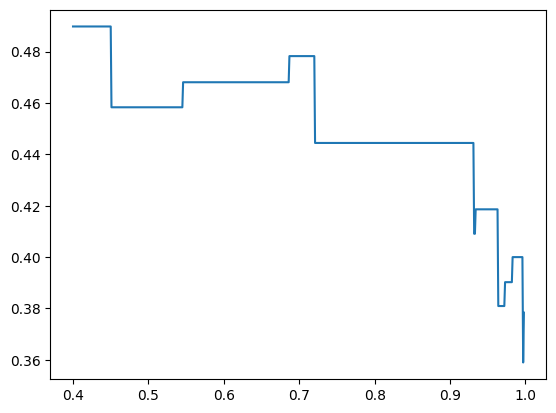

In [25]:

tresh = np.arange(0.4, 0.999, 0.001)
pre = []
rec = []
f1s = []


for treshi in tresh:
  def evaluate_model_accuracy(model, X_values, y_true, threshold=treshi):
      model.eval()
      total_correct = 0
      total_predicted = 0
      total_actual = 0

      with torch.no_grad():
          for i in range(len(X_values)):
              model_output = model(X_values[i].unsqueeze(0)).squeeze()
              predicted_indices = set(get_indices_above_threshold(model_output, threshold))
              actual_indices = set(get_indices_above_threshold(y_true[i], threshold))

              correct = predicted_indices.intersection(actual_indices)
              total_correct += len(correct)
              total_predicted += len(predicted_indices)
              total_actual += len(actual_indices)

      precision = total_correct / total_predicted if total_predicted > 0 else 0
      recall = total_correct / total_actual if total_actual > 0 else 0
      f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

      print(f"Precision: {precision:.4f}(Positive guesses/inverse Proportional to false positive rate)")
      print(f"Recall: {recall:.4f} (Negative Guesses/Inverse Proportional to false negative rate.)")
      print(f"F1 Score: {f1_score:.4f}(total performance!)")

      return precision, recall, f1_score

  # Usage
  precision, recall, f1_score = evaluate_model_accuracy(nn_model, Y_test, Labels_test)
  pre.append(precision)
  rec.append(recall)
  f1s.append(f1_score)

#plt.plot(tresh, pre, label='Precision')
#plt.plot(tresh, rec, label='Recall')
plt.plot(tresh, f1s, label='F1 Score')

max_f1 = max(f1s)
max_index = f1s.index(max_f1)
print(f"Maximum F1 Score: {max_f1:.4f} at Threshold: {tresh[max_index]:.4f}")


In [ ]:
# Export the model for future training
torch.save({
    'model_state_dict': nn_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item()
}, 'ir_model_checkpoint_(4L)_(L2)_v1.pth')

print("Model saved successfully for future training.")


In [ ]:
# Assuming you have defined your model architecture (nn_model) beforehand

# Load the checkpoint
checkpoint = torch.load('ir_model_checkpoint_(4L)_(L2)_v1.pth')

# Load the model state dictionary
nn_model.load_state_dict(checkpoint['model_state_dict'])

# If you want to continue training, you can also load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to evaluation mode if you're using it for inference
#nn_model.eval()

print("Model loaded successfully.")